In [1]:
#Import the required libraries
import warnings as w
w.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

E0000 00:00:1761842791.988756      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761842792.055258      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#Fetching the stock data
def fetch_stock_data(ticker="AAPL", start="2015-01-01", end="2025-01-01"):
    df = yf.download(ticker, start=start, end=end)
    df = df[['Open','High','Low','Close','Volume']].dropna()
    df = df.asfreq('B', method='ffill')
    df.to_csv(f"{ticker}_raw.csv")
    print(f"Raw data saved: {ticker}_raw.csv")
    return df

In [3]:
#Preprocessing the data
def preprocess_data(df):
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    df_scaled.to_csv("processed_stock.csv")
    print("Processed data saved: processed_stock.csv")
    return df_scaled, scaler

In [4]:
#Arima Forecast visualization
def arima_forecast(df, column='Close', order=(5,1,0), steps=30):
    model = ARIMA(df[column], order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    
    plt.figure(figsize=(10,5))
    plt.plot(df[column], label="Actual")
    plt.plot(forecast, label="ARIMA Forecast", color='red')
    plt.title("ARIMA Forecast")
    plt.legend()
    plt.show()
    return forecast

In [5]:
#Prophet Forecast visualization
def prophet_forecast(df, column='Close', periods=30):
    df_prophet = df[[column]].reset_index()
    df_prophet.columns = ['ds','y']
    
    model = Prophet(daily_seasonality=True)
    model.fit(df_prophet)
    
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    
    model.plot(forecast)
    plt.title("Prophet Forecast")
    plt.show()
    
    return forecast[['ds','yhat','yhat_lower','yhat_upper']]

In [6]:
#Creating the data sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [7]:
#LSTM Forecast visualization
def lstm_forecast(df, column='Close', seq_length=50, epochs=20, batch_size=32, forecast_steps=30):
    data = df[column].values.reshape(-1,1)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    
    X, y = create_sequences(data_scaled, seq_length)
    
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(seq_length,1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    
    forecast_input = data_scaled[-seq_length:]
    forecast = []
    for _ in range(forecast_steps):
        pred = model.predict(forecast_input.reshape(1, seq_length, 1))
        forecast.append(pred[0,0])
        forecast_input = np.append(forecast_input[1:], pred[0,0])
    
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1,1))
    
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df[column], label="Actual")
    future_index = pd.date_range(df.index[-1]+pd.Timedelta(days=1), periods=forecast_steps)
    plt.plot(future_index, forecast, label="LSTM Forecast", color='green')
    plt.title("LSTM Forecast")
    plt.legend()
    plt.show()
    
    return forecast

[*********************100%***********************]  1 of 1 completed


Raw data saved: AAPL_raw.csv
Processed data saved: processed_stock.csv
Running ARIMA Forecast...


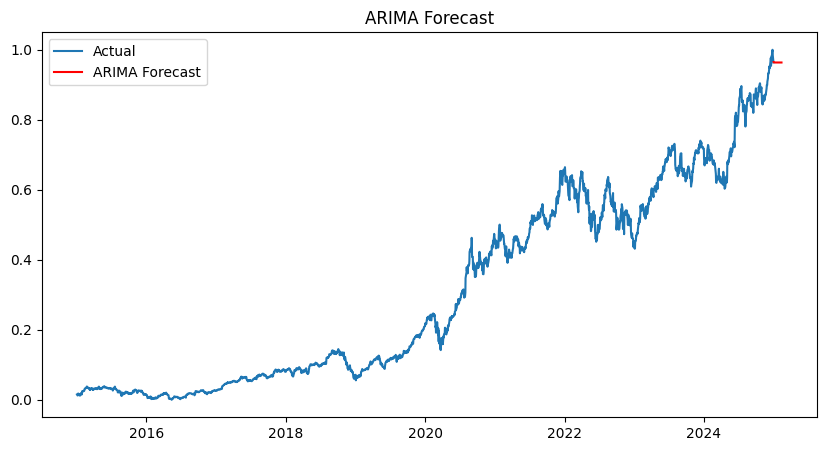

Running Prophet Forecast...


16:49:40 - cmdstanpy - INFO - Chain [1] start processing
16:49:41 - cmdstanpy - INFO - Chain [1] done processing


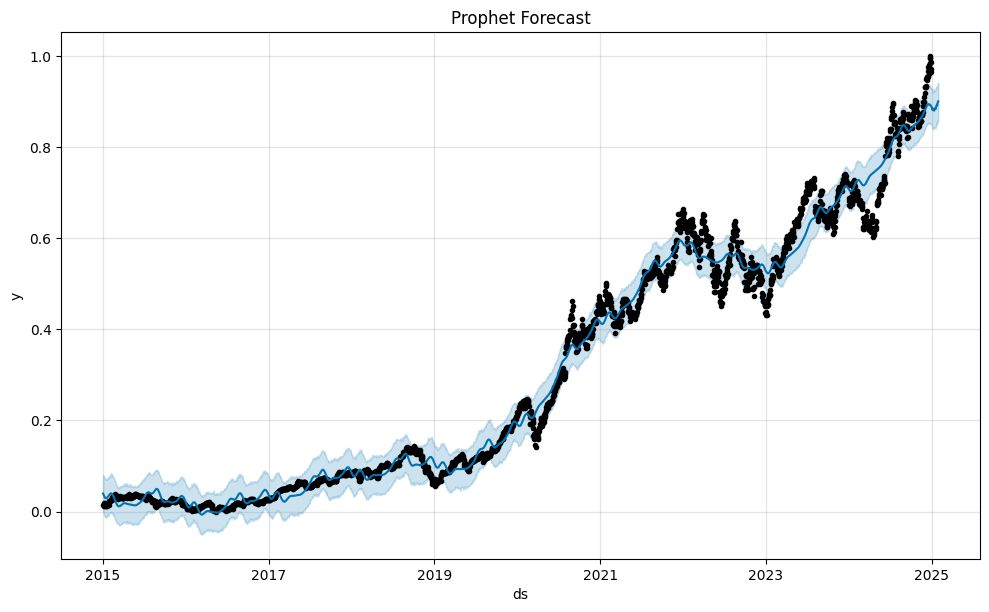

Running LSTM Forecast...


I0000 00:00:1761842983.219017      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761842983.219755      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/20


I0000 00:00:1761842987.024647     119 service.cc:148] XLA service 0x796f3800b850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761842987.025324     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761842987.025342     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761842987.333271     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


19/80 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1192

I0000 00:00:1761842988.638095     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0659
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 13/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 14/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 15/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 16/20
80/80 ━━━━━━━━━━━

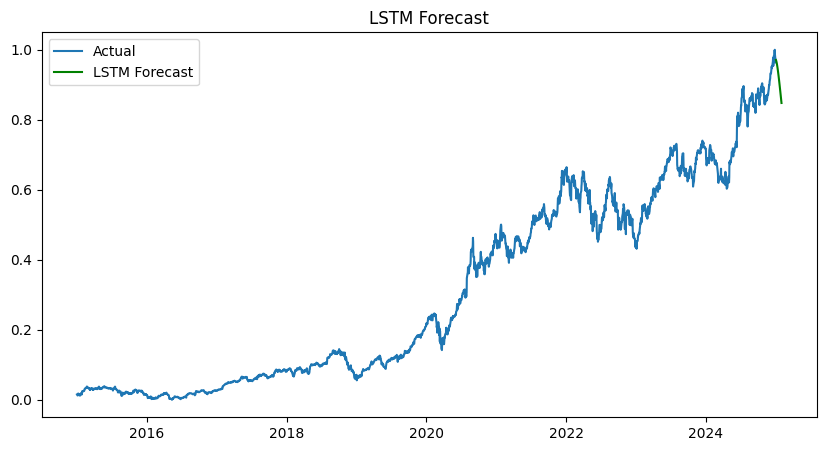

In [8]:
#Main() Function
if __name__ == "__main__":
    ticker = "AAPL"
    raw_df = fetch_stock_data(ticker)
    processed_df, scaler = preprocess_data(raw_df)
    
    print("Running ARIMA Forecast...")
    arima_forecast(processed_df)
    
    print("Running Prophet Forecast...")
    prophet_forecast(processed_df)
    
    print("Running LSTM Forecast...")
    lstm_forecast(processed_df)